# LPL in a deep network - Figure 3

This notebook is used to generate Figure 3 for the STL-10 dataset and the analagous plot for CIFAR-10 given in Extended Data Figure 11a.

## Preparation

Prior to running the notebook, make sure you have completed the following steps. This can take a while, so we recommend running the training scripts on a cluster with multiple GPUs.

1. Train network models using different variants of the learning rule. You need to have run at least one set of random seeds for five configurations - i) default LPL, ii) removing the predictive term, iii) removing the Hebbian term, iv) removing the decorrelation term, and v) random pairs of images (LPL shuffled). This can be done by running `lpl_main.py` with the following options:
```
python lpl_main.py --random_seed 1 --experiment_name run_1
python lpl_main.py --random_seed 1 --experiment_name pred_off_1 --pull_coeff 0.
python lpl_main.py --random_seed 1 --experiment_name hebb_off_1 --push_coeff 0.
python lpl_main.py --random_seed 1 --experiment_name decorr_off_1 --decorr_coeff 0.
python lpl_main.py --random_seed 1 --experiment_name shuffled_1 --shuffle_positives
```

2. Run the evaluation script for the above experiments after training:
```
python eval.py --dataset cifar10 --experiment_dir ~/data/lpl/cifar10/run_1
python eval.py --dataset cifar10 --experiment_dir ~/data/lpl/cifar10/pred_off_1/
python eval.py --dataset cifar10 --experiment_dir ~/data/lpl/cifar10/hebb_off_1/
python eval.py --dataset cifar10 --experiment_dir ~/data/lpl/cifar10/decorr_off_1/
python eval.py --dataset cifar10 --experiment_dir ~/data/lpl/cifar10/shuffled_1/
```
This will generate a yaml file `results.yaml` for each experiment, all of which are read by this notebook for plotting.

3. Use this notebook to generate the plots for Figure 3 once you have trained and evaluated the different configurations.

### Training different settings and datasets
You can run the above code for other experiments.
- For instance, you can run the above steps with backpropagation, simply add the flag `--train_end_to_end` when running the training code. 
- To minimize computational requirements, the code runs on the CIFAR-10 dataset by default. Repeat the same steps for the STL-10 dataset using `--dataset stl10`. 

To run the analysis on these variations and generate the corresponding `results.yaml` file, invoke the evaluation code as follows:
```python eval.py --dataset $DATASET --experiment_dir $EXPERIMENT_DIR```
, where `$DATASET` is either `cifar10` or `stl10`, and `$EXPERIMENT_DIR` is the path to the experiment directory, located by default at `~/data/lpl/$DATASET/$EXPERIMENT_NAME`.

### Note on multiple random seeds
You can change the random seed as desired. To run the notebooks smoothly, please follow the naming scheme suggested above for the experiment names. End-to-end training experiments should share the same names. 
Simply increment the subscript for each extra set of runs, like so - `python lpl_main.py --experiment_name pred_off_2 --seed 42 --pull_coeff 0. --train_end_to_end`. This will ensure that the notebooks can read the data files correctly.

## Analysis

In [1]:
# By default we generate plots for CIFAR, but this can be changed by setting `dataset = 'stl10'`
dataset = 'cifar10'

# You need to modify `num_runs` according to how many separate random seeds you ran.
num_runs = 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

import yaml
import os
import project_path

In [3]:
logdir = os.path.expanduser("~/data/lpl/{}".format(dataset))
outputdir = os.path.expanduser("~/data/lpl/plots/fig_deep_networks")
os.makedirs(outputdir, exist_ok=True)

### Read in results files

In [4]:
paths = {}

dims = {}
accs = {}
act_norms = {}

In [5]:
paths['lpl'] = 'run_'
# paths['lpl_e2e'] = 'run_'

paths['pred_off'] = 'pred_off_'
# paths['pred_off_e2e'] = 'pred_off_'

paths['hebb_off'] = 'hebb_off_'
# paths['hebb_off_e2e'] = 'hebb_off_'

paths['decorr_off'] = 'decorr_off_'
# paths['decorr_off_e2e'] = 'decorr_off_'

paths['lpl_shuffled'] = 'shuffled_'

In [6]:
for key in paths:
    accs[key] = []
    dims[key] = []
    act_norms[key] = []

In [7]:
for key in paths:
    model_descr = 'lpl_end-to-end' if 'e2e' in key else 'lpl'
    for i in range(num_runs):
        path = os.path.join(logdir, paths[key] + str(i+1))
        # Read results.yaml file
        with open(os.path.join(path, 'results.yaml'), 'r') as f:
            results = yaml.load(f, Loader=yaml.FullLoader)
        accs[key].append(results[model_descr]['acc'])
        dims[key].append(results[model_descr]['pr'])
        act_norms[key].append(results[model_descr]['mean_acts'])
    
    # Convert to numpy arrays
    accs[key] = np.array(accs[key])
    dims[key] = np.array(dims[key])
    act_norms[key] = np.array(act_norms[key])

In [8]:
# get mean and std for each metric
mean_accs = {}
err_accs = {}
mean_dims = {}
err_dims = {}
mean_act_norms = {}
err_act_norms = {}

for key in paths:
    mean_accs[key] = np.mean(accs[key], axis=0).squeeze()
    err_accs[key] = np.std(accs[key], axis=0).squeeze() / np.sqrt(num_runs)
    mean_dims[key] = np.nan_to_num(np.mean(dims[key], axis=0).squeeze())
    err_dims[key] = np.nan_to_num(np.std(dims[key], axis=0).squeeze() / np.sqrt(num_runs))
    mean_act_norms[key] = np.mean(act_norms[key], axis=0).squeeze()
    err_act_norms[key] = np.std(act_norms[key], axis=0).squeeze() / np.sqrt(num_runs)

In [9]:
mean_last_layer_accs = {}
err_last_layer_accs = {}
mean_last_layer_dims = {}
err_last_layer_dims = {}

for key in paths:
    mean_last_layer_accs[key] = mean_accs[key][-1].item()
    err_last_layer_accs[key] = err_accs[key][-1].item()
    mean_last_layer_dims[key] = mean_dims[key][-1].item()
    err_last_layer_dims[key] = err_dims[key][-1].item()

### Linear readout accuracy at the last layer

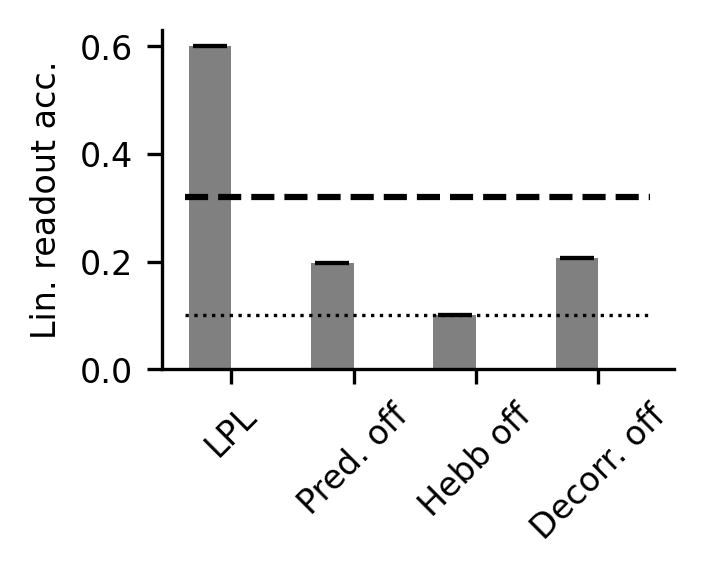

In [10]:
plt.figure(figsize=(2.2, 1.5), dpi=300)

barWidth = 0.35

r1 = np.arange(4)
# r2 = [x + barWidth for x in r1]

pixel_readout_acc = 0.32

plt.bar(r1, [mean_last_layer_accs['lpl'], mean_last_layer_accs['pred_off'], mean_last_layer_accs['hebb_off'], mean_last_layer_accs['decorr_off']], color ='gray', width = barWidth, 
        yerr = [err_last_layer_accs['lpl'], err_last_layer_accs['pred_off'], err_last_layer_accs['hebb_off'], err_last_layer_accs['decorr_off']], label='Layer-local', capsize=4)
# plt.bar(r2, [mean_last_layer_accs['lpl_e2e'], mean_last_layer_accs['pred_off_e2e'], mean_last_layer_accs['hebb_off_e2e'], mean_last_layer_accs['decorr_off_e2e']], color ='gray', width = barWidth, 
#         yerr = [err_last_layer_accs['lpl_e2e'], err_last_layer_accs['pred_off_e2e'], err_last_layer_accs['hebb_off_e2e'], err_last_layer_accs['decorr_off_e2e']], label='End-to-end', alpha=0.5, capsize=4)
plt.xticks([r + 0.5*barWidth for r in range(len(r1))], ['LPL', 'Pred. off', 'Hebb off', 'Decorr. off'], fontsize=8)
plt.hlines(0.1, -0.2, 3.6, color='k', linewidth=0.8, linestyle='dotted', label='Chance level')
plt.hlines(pixel_readout_acc, -0.2, 3.6, color='k', linestyle='--', label='Pixel readout')
# plt.hlines(mean_accs['supervised'], -0.2, 2.6, color='k', linestyle='-.', label='Supervised')
plt.ylabel('Lin. readout acc.', fontsize=8)

# handles,labels = plt.gca().get_legend_handles_labels()
# handles = [handles[2], handles[3], handles[1], handles[0]]
# labels = [labels[2], labels[3], labels[1], labels[0]]
# lgd = plt.legend(handles, labels, frameon=False, fontsize=6)

plt.xticks(rotation=45, fontsize=8)
# plt.tight_layout()
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
sns.despine()
plt.savefig(os.path.join(outputdir,'deep_net_acc_{}.pdf'.format(dataset)), bbox_inches='tight')

### Linear readout accuracy at different layers

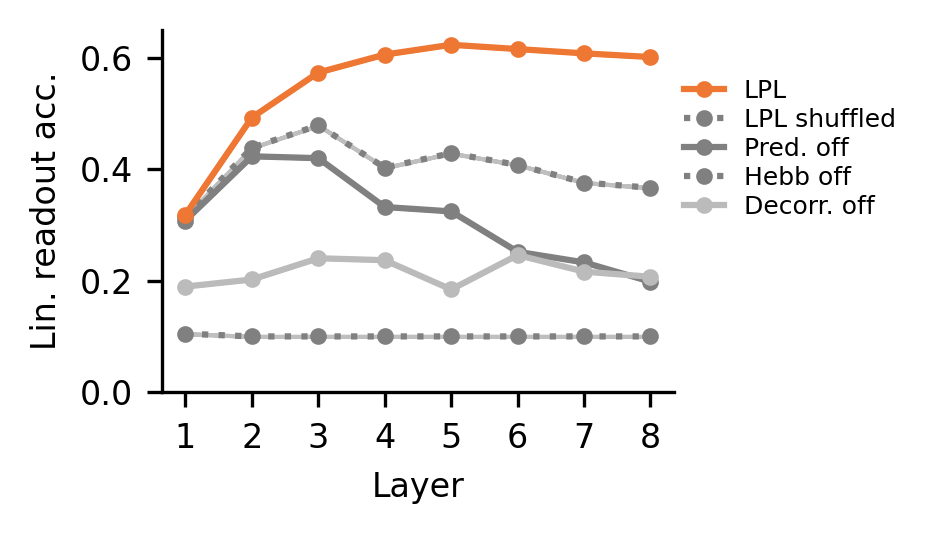

In [11]:
plt.figure(figsize=(2.2,1.6), dpi=300)

plt.plot(range(1,9), mean_accs['lpl'], color='#EE7733', label='LPL', marker='.', zorder=4)
plt.fill_between(range(1,9), mean_accs['lpl']-err_accs['lpl'], mean_accs['lpl']+err_accs['lpl'], color='#EE7733', alpha=0.5, zorder=4)

plt.plot(range(1,9), mean_accs['lpl_shuffled'], color='gray', label='LPL shuffled', marker='.', linestyle=':', zorder=3)
plt.fill_between(range(1,9), mean_accs['lpl_shuffled']-err_accs['lpl_shuffled'], mean_accs['lpl_shuffled']+err_accs['lpl_shuffled'], color='gray', alpha=0.5, zorder=3)

plt.plot(range(1,9), mean_accs['pred_off'], color='gray', label='Pred. off', marker='.')
plt.fill_between(range(1,9), mean_accs['pred_off']-err_accs['pred_off'], mean_accs['pred_off']+err_accs['pred_off'], color='gray', alpha=0.5)

plt.plot(range(1,9), mean_accs['hebb_off'], color='gray', label='Hebb off', marker='.', linestyle=':')
plt.fill_between(range(1,9), mean_accs['hebb_off']-err_accs['hebb_off'], mean_accs['hebb_off']+err_accs['hebb_off'], color='gray', alpha=0.5)

plt.plot(range(1,9), mean_accs['decorr_off'], color='#BBBBBB', label='Decorr. off', marker='.')
plt.fill_between(range(1,9), mean_accs['decorr_off']-err_accs['decorr_off'], mean_accs['decorr_off']+err_accs['decorr_off'], color='#BBBBBB', alpha=0.5)

plt.xlabel('Layer', fontsize=8)
plt.ylabel('Lin. readout acc.', fontsize=8)
plt.xticks(range(1,9))
plt.ylim(0,0.65)

lgd = plt.legend(frameon=False, fontsize=6, handlelength=1.6, loc=(1.0,0.45), labelspacing=0.2)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
sns.despine()

plt.savefig(os.path.join(outputdir,'deep_net_layerwise_acc_{}.pdf'.format(dataset)), bbox_inches='tight', backend='pgf')

### Representational dimensionality (participation ratio) at the last layer

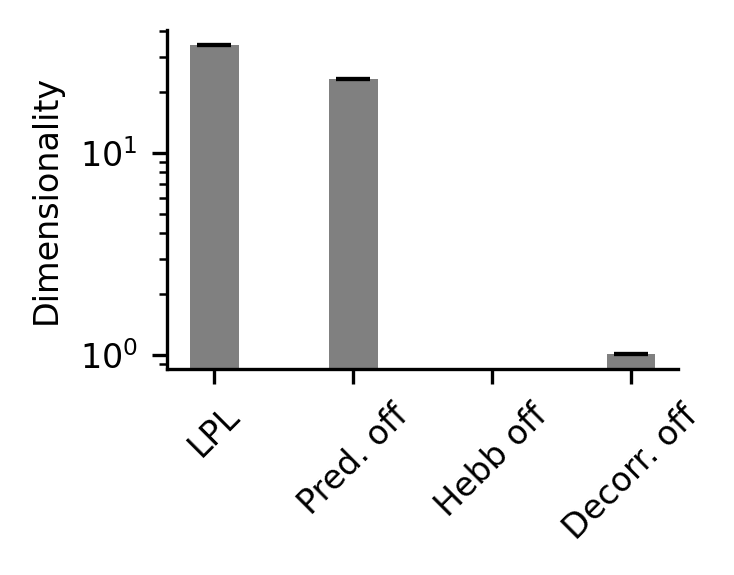

In [12]:
plt.figure(figsize=(2.2, 1.5), dpi=300)

barWidth = 0.35

r1 = np.arange(4)
r2 = [x + barWidth for x in r1]

plt.bar(r1, [mean_last_layer_dims['lpl'], mean_last_layer_dims['pred_off'], mean_last_layer_dims['hebb_off'], mean_last_layer_dims['decorr_off']], color ='gray', width = barWidth,
        yerr = [err_last_layer_dims['lpl'], err_last_layer_dims['pred_off'], err_last_layer_dims['hebb_off'], err_last_layer_dims['decorr_off']], label='Layer-local', capsize=4)
plt.xticks(r1, ['LPL', 'Pred. off', 'Hebb off', 'Decorr. off'], fontsize=8)
plt.ylabel('Dimensionality', fontsize=8)
plt.xticks(rotation=45, fontsize=8)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.set_yscale('log')
sns.despine()

plt.savefig(os.path.join(outputdir,'deep_net_dim_{}.pdf'.format(dataset)), bbox_inches='tight')

### Mean unit activations at different layers

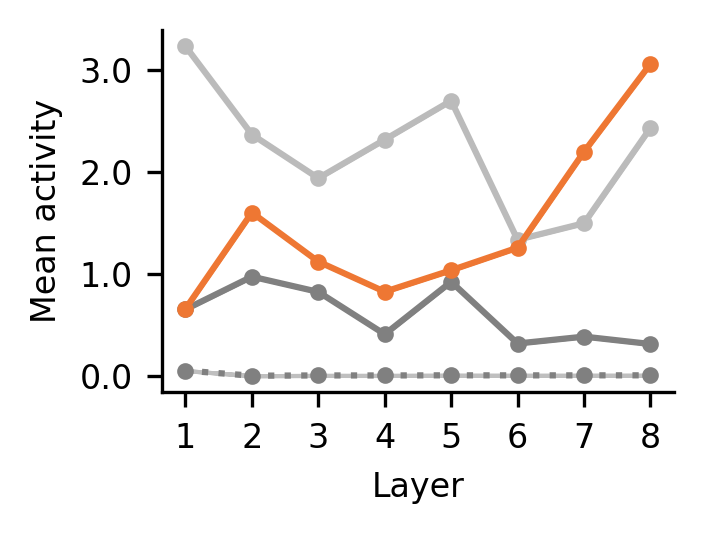

In [13]:
plt.figure(figsize=(2.2, 1.6), dpi=300)

plt.plot(range(1,9), mean_act_norms['lpl'], color='#EE7733', label='LPL', marker='.', zorder=4)
plt.fill_between(range(1,9), mean_act_norms['lpl']-err_act_norms['lpl'], mean_act_norms['lpl']+err_act_norms['lpl'], color='#EE7733', alpha=0.5, zorder=4)

plt.plot(range(1,9), mean_act_norms['pred_off'], color='gray', label='Pred. off', marker='.')
plt.fill_between(range(1,9), mean_act_norms['pred_off']-err_act_norms['pred_off'], mean_act_norms['pred_off']+err_act_norms['pred_off'], color='gray', alpha=0.5)

plt.plot(range(1,9), mean_act_norms['hebb_off'], color='gray', label='Hebb off', marker='.', linestyle=':')
plt.fill_between(range(1,9), mean_act_norms['hebb_off']-err_act_norms['hebb_off'], mean_act_norms['hebb_off']+err_act_norms['hebb_off'], color='gray', alpha=0.5)

plt.plot(range(1,9), mean_act_norms['decorr_off'], color='#BBBBBB', label='Decorr. off', marker='.')
plt.fill_between(range(1,9), mean_act_norms['decorr_off']-err_act_norms['decorr_off'], mean_act_norms['decorr_off']+err_act_norms['decorr_off'], color='#BBBBBB', alpha=0.5)

plt.xlabel('Layer', fontsize=8)
plt.ylabel('Mean activity', fontsize=8)
plt.xticks(range(1,9))

# lgd = plt.legend(frameon=False, fontsize=6)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
sns.despine()

plt.savefig(os.path.join(outputdir,'deep_net_layerwise_act_norm_{}.pdf'.format(dataset)), bbox_inches='tight', backend='pgf')